In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

In [2]:
cases_raw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
death_raw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

In [3]:
confirmed = cases_raw.drop(['Lat','Long'], axis = 1)
deaths = death_raw.drop(['Lat','Long'], axis = 1)


def set_country_res(df):

    df_sans_provinces = df.drop('Province/State', axis=1)
    df_sans_provinces = df_sans_provinces.groupby('Country/Region').sum()
    
    return df_sans_provinces

confirmed = set_country_res(confirmed)
deaths = set_country_res(deaths)

confirmed.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831
Albania,0,0,0,0,0,0,0,0,0,0,...,946,948,949,964,969,981,989,998,1004,1029
Algeria,0,0,0,0,0,0,0,0,0,0,...,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697
Andorra,0,0,0,0,0,0,0,0,0,0,...,761,761,761,762,762,762,762,762,763,763
Angola,0,0,0,0,0,0,0,0,0,0,...,48,50,52,52,58,60,61,69,70,70


In [4]:
# Calculate death rate for each country
# Get most recent numbers for recovered and deaths (last column in the data table)
total_confirmed = confirmed[confirmed.columns[-1]]
total_deaths = deaths[deaths.columns[-1]]

death_rate = pd.Series(dtype = float)

# Calculating death rate
if (total_deaths.index == total_confirmed.index).all():
    death_rate = total_deaths/(total_confirmed + total_deaths)
else:
    print('Whoops, looks like your countries dont match')

# Drop countries that have a null death rate (don't have any cases)
death_rate.dropna(inplace=True)
death_rate = pd.DataFrame(death_rate)
death_rate.rename(columns={death_rate.columns[0]:'death_rate'},inplace=True)
death_rate.index.names = ['Country']
print(death_rate)

                    death_rate
Country                       
Afghanistan           0.018256
Albania               0.031073
Algeria               0.066244
Andorra               0.062654
Angola                0.054054
...                        ...
West Bank and Gaza    0.006944
Western Sahara        0.100000
Yemen                 0.164430
Zambia                0.007551
Zimbabwe              0.066667

[188 rows x 1 columns]


In [ ]:
# Finding how many countries we lost in our naive merge
print(f'We lost {death_rate.shape[0] - naive_merge.shape[0]} countries in our naive merge')
# Finding the countries we lost
right_merge = full.merge(death_rate,left_index=True, right_index=True, how='right')
right_merge[right_merge['Date Start'].isna()]

In [6]:
# https://www.kaggle.com/paultimothymooney/covid19-containment-and-mitigation-measures
containment = pd.read_csv('COVID 19 Containment measures data.csv')
containment = containment.drop(['ID','Description of measure implemented','Applies To', 'Quantity',
                                'Target country', 'Target region', 'Target state','Implementing State/Province',
                                'Source', 'Target city','Implementing City','Exceptions'],axis=1)
containment['Date Start'] = containment['Date Start'].astype('datetime64[ns]')
containment['Date end intended'] = containment['Date end intended'].astype('datetime64[ns]')

In [7]:
keyword = containment.groupby('Country')['Keywords'].apply(lambda x: ','.join(x.astype(str))).reset_index()
date = containment.sort_values('Date Start').drop_duplicates(subset='Country', keep='last')
date = date[date['Date Start'].notna()]
date = date.set_index("Country")
date = date.drop('Keywords',axis=1)
keyword = keyword.set_index("Country")
date
full = date.merge(keyword, on='Country')

In [8]:
full['international_ban'] = np.where(full['Keywords'].str.contains("international travel ban", case=False, na=False),
                                     True, False)
full['school_close'] = np.where(full['Keywords'].str.contains("school closure", case=False, na=False),
                                     True, False)
full['university_close'] = np.where(full['Keywords'].str.contains("university closure", case=False, na=False),
                                     True, False)
full['international_ban'] = np.where(full['Keywords'].str.contains("international travel ban", case=False, na=False),
                                     True, False)
full['nonessential_business_suspend'] = np.where(full['Keywords'].str.contains("nonessential business suspension", case=False, na=False),
                                     True, False)
full['contact_tracing'] = np.where(full['Keywords'].str.contains("contact tracing", case=False, na=False),
                                     True, False)
full['hygiene'] = np.where(full['Keywords'].str.contains("hygiene", case=False, na=False),
                                     True, False) 
full['phone_tracing'] = np.where(full['Keywords'].str.contains("phone based location", case=False, na=False),
                                     True, False)
full['remote_work'] = np.where(full['Keywords'].str.contains("remote work", case=False, na=False),
                                     True, False)

In [9]:
# Merging death rate and median age 
naive_merge = full.merge(death_rate,left_index=True, right_index=True)
naive_merge

,Date Start,Date end intended,Keywords,international_ban,school_close,university_close,nonessential_business_suspend,contact_tracing,hygiene,phone_tracing,remote_work,death_rate
Country,,,,,,,,,,,,
Trinidad and Tobago,2020-02-01,NaT,international travel ban - risk countries,True,False,False,False,False,False,False,False,0.064516
Azerbaijan,2020-03-04,NaT,"case reporting, first case, traveller testing,...",True,True,True,False,False,False,False,False,0.011672
Iraq,2020-03-09,NaT,"first case,cluster isolation - no symptoms,sch...",False,True,False,True,False,False,False,False,0.033685
Kyrgyzstan,2020-03-13,NaT,testing numbers total,False,False,False,False,False,False,False,False,0.010782
San Marino,2020-03-14,2020-04-06,"blanket isolation - no symptoms,case reporting...",False,False,False,False,True,False,True,False,0.059322
Kosovo,2020-03-15,NaT,"case reporting, first case,public announcement...",False,False,False,False,False,False,False,False,0.028090
United Arab Emirates,2020-03-16,NaT,testing numbers total,False,False,False,False,False,False,False,False,0.008073
Morocco,2020-03-16,NaT,"first case,school closure, university closure",False,True,True,False,False,False,False,False,0.025967
Monaco,2020-03-16,NaT,"nursery school closure, school closure, univer...",False,True,True,False,False,False,False,False,0.039216


In [20]:
y = naive_merge['death_rate']
X = naive_merge.drop(["death_rate",'Date Start','Date end intended','Keywords'], axis=1)

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [22]:
# function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [23]:
print(score_dataset(X_train, X_valid, y_train, y_valid))

0.025356196843028516


In [37]:
def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    model= RandomForestRegressor(n_estimators, random_state=0)
    scores = -1 * cross_val_score(model, X, y,
                              cv=4,
                              scoring='neg_mean_absolute_error')
    return scores.mean()


In [38]:
results={} # Your code here
for i in range(1,10):
    results[50*i] = get_score(50*i)

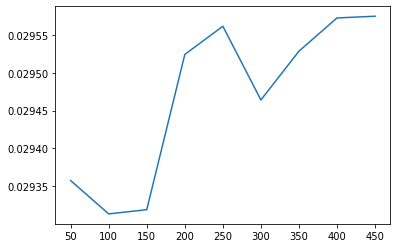

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()
# BEst n_estimators is 100